2025-11-03 09:03:05.054910: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762160585.247021      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762160585.307532      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


================== Starting Training for 10x10 vs 400x400 ==================
Found potential Reynolds numbers in file: [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000, 1050, 1100, 1150]

Training on 42 samples (from Re: [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700])
Testing on 27 samples (from Re: [750, 800, 850, 900, 950, 1000, 1050, 1100, 1150])
Building model components...


I0000 00:00:1762160600.368074      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1762160600.368868      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


✅ Models built successfully for LR=10 and HR=400.

🚀 Starting Super-Resolution AE training (10x10 -> 400x400)...


I0000 00:00:1762160606.762584      64 service.cc:148] XLA service 0x7ab0fc005b10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762160606.763235      64 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1762160606.763258      64 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1762160607.291051      64 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1762160611.931366      64 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


✅ Training finished.
✅ Starting evaluation loop...

▶️ Evaluating for Re=1000
  - Component 'U': MAE=0.0102, NMAE=0.74%


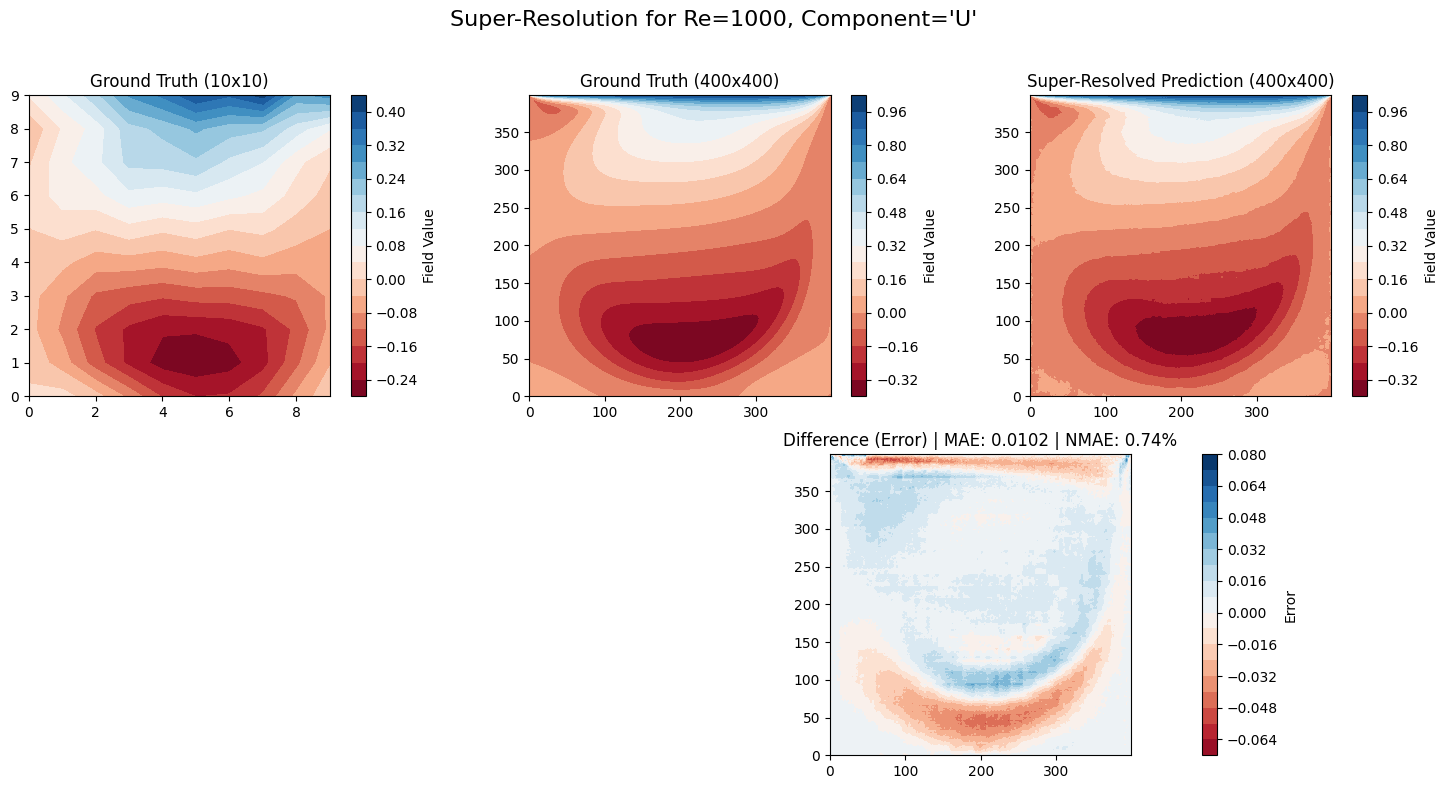

  - Component 'V': MAE=0.0087, NMAE=0.82%


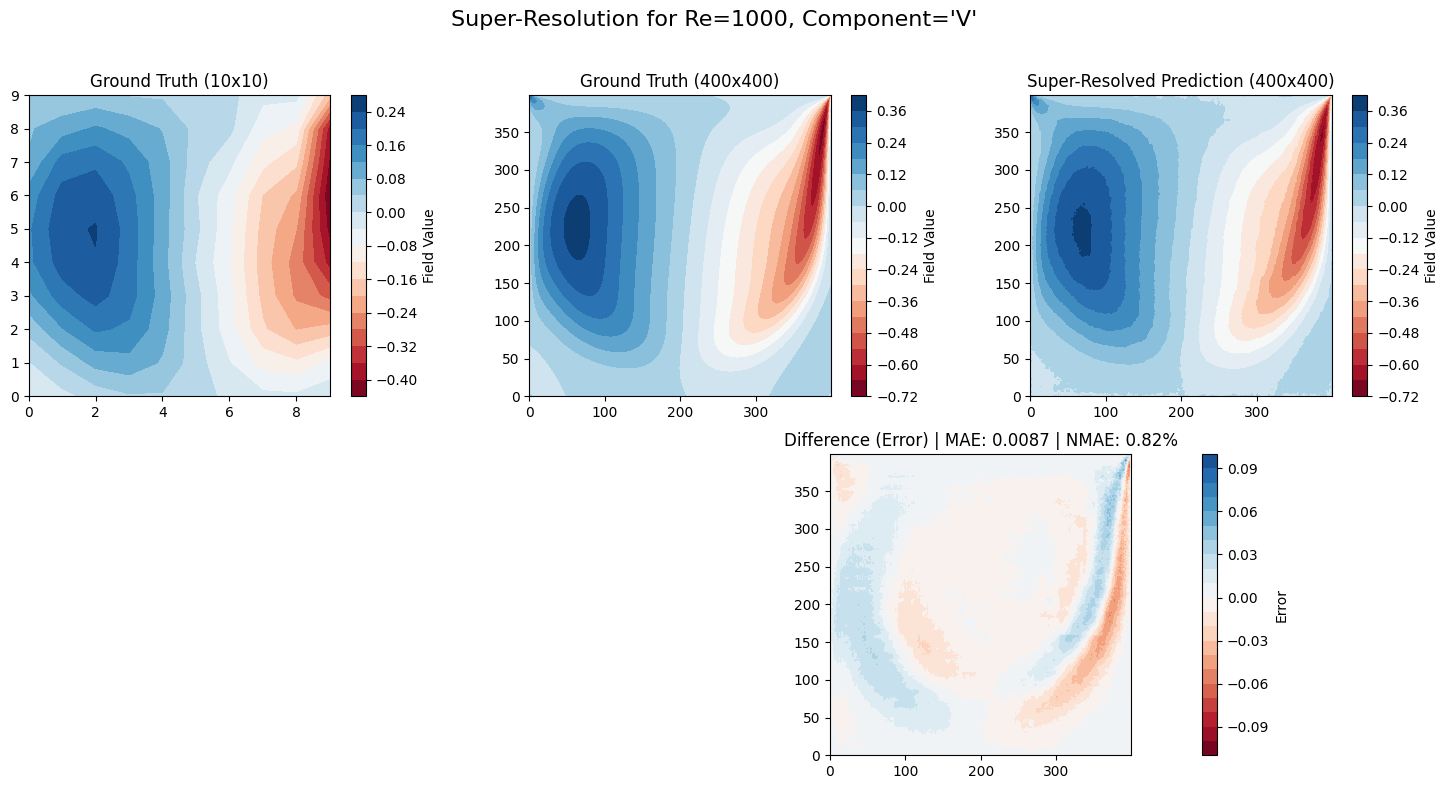

  - Component 'P': MAE=0.0031, NMAE=0.13%


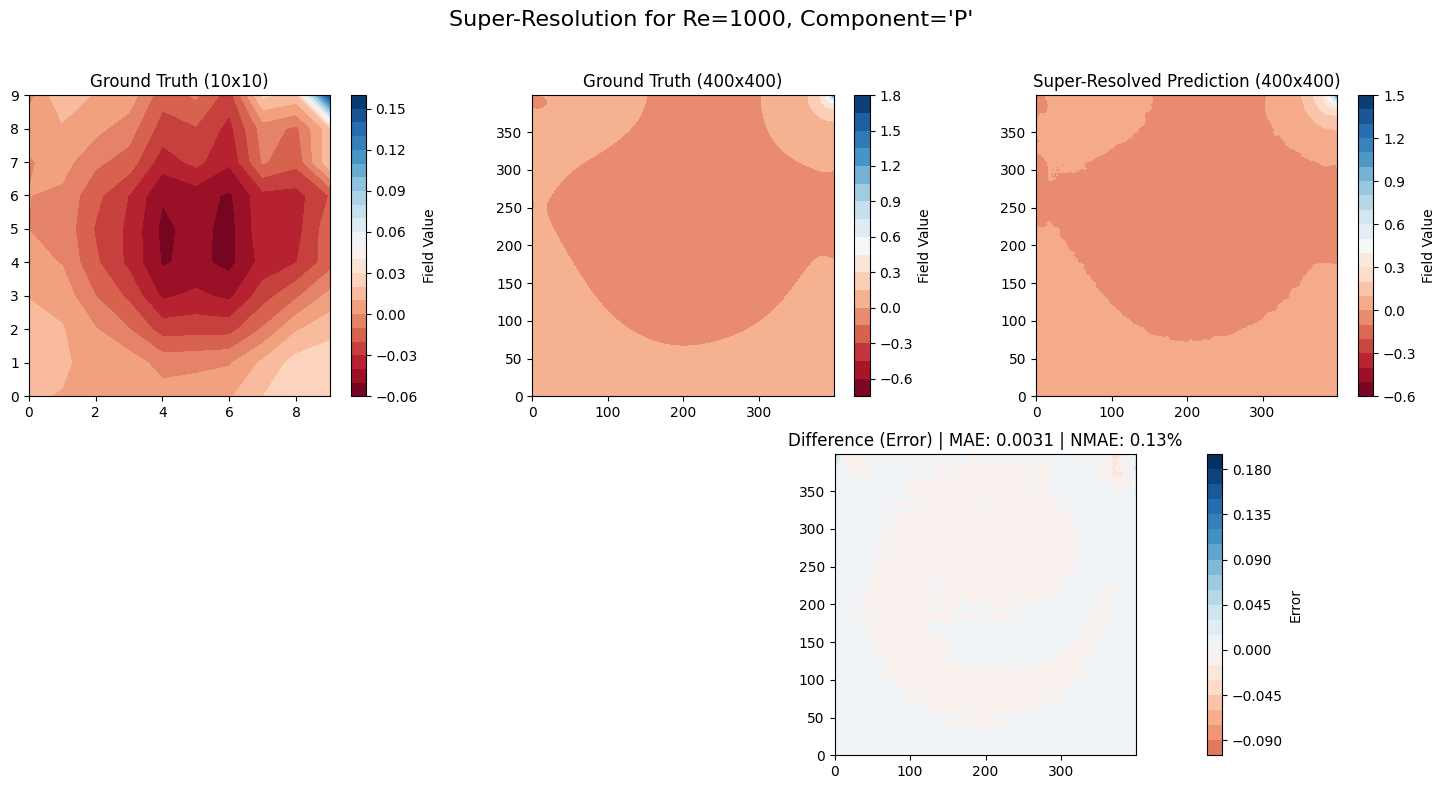


📊 Average Metrics for 10x10 -> 400x400 Super-Resolution:
  - Average MAE: 0.0073
  - Average NMAE: 0.57%

💾 Saving models and stats...
✅ Done for 10x10 vs 400x400.


In [ ]:
# (Keep all imports and helper functions the same)
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
import h5py
import matplotlib.gridspec as gridspec

# ========================= MODIFICATION: PARAMETERIZE DATA LOADING =========================
def load_paired_reynolds(file_path, lr_dim, hr_dim):
    """
    Scans the HDF5 file to find available Reynolds numbers, then loads only the
    paired data for the specified lr_dim and hr_dim meshes for all components (u, v, p).
    """
    xs_lr, xs_hr, used_res, components = [], [], [], []
    try:
        with h5py.File(file_path, 'r') as f:
            all_keys = list(f.keys())
            if not all_keys: raise RuntimeError(f"HDF5 file at {file_path} is empty.")
            re_numbers_in_file = sorted(list(set(int(k.split('_')[0][2:]) for k in all_keys if k.startswith("Re"))))
            print(f"Found potential Reynolds numbers in file: {re_numbers_in_file}")
            for Re in re_numbers_in_file:
                g_lr = f"Re{Re}_mesh{lr_dim}x{lr_dim}"
                g_hr = f"Re{Re}_mesh{hr_dim}x{hr_dim}"
                if g_lr in all_keys and g_hr in all_keys:
                    # For each component, load the data
                    for comp in ['u', 'v', 'p']:
                        if comp in f[g_lr] and comp in f[g_hr]:
                            xs_lr.append(f[g_lr][comp][()].astype(np.float32).reshape(lr_dim, lr_dim))
                            xs_hr.append(f[g_hr][comp][()].astype(np.float32).reshape(hr_dim, hr_dim))
                            used_res.append(Re)
                            components.append(comp)

        if len(xs_lr) == 0: raise RuntimeError(f"No paired {lr_dim}x{lr_dim} and {hr_dim}x{hr_dim} groups found for any component.")
        return np.array(xs_lr, dtype=np.float32)[..., None], np.array(xs_hr, dtype=np.float32)[..., None], np.array(used_res), np.array(components)
    except (IOError, OSError, FileNotFoundError):
        print(f"⚠️ Error: Could not open file at '{file_path}'. Creating paired dummy data.")
        N = 20  # Number of Reynolds numbers
        factor = hr_dim // lr_dim
        if hr_dim % lr_dim != 0: raise ValueError("For dummy data, hr_dim must be a multiple of lr_dim.")
        
        # Create dummy data for each component
        for comp in ['u', 'v', 'p']:
            x_hr_comp = np.random.randn(N, hr_dim, hr_dim, 1).astype(np.float32)
            x_lr_comp = tf.nn.avg_pool(x_hr_comp, ksize=factor, strides=factor, padding='VALID').numpy()
            xs_lr.extend(x_lr_comp)
            xs_hr.extend(x_hr_comp)
            used_res.extend(np.arange(50, 50*N+1, 50))
            components.extend([comp] * N)
            
        return np.array(xs_lr, dtype=np.float32), np.array(xs_hr, dtype=np.float32), np.array(used_res), np.array(components)

def dataset_standardize(arr): mean, std = np.mean(arr, dtype=np.float64), np.std(arr, dtype=np.float64); std=1e-8 if std==0 else std; return (arr-mean)/std, float(mean), float(std)
def standardize_with_stats(arr, mean, std): std=1e-8 if std==0 else std; return (arr-mean)/std
def inverse_standardize(arr, mean, std): return arr*std+mean

# ----------------------
# PLOTTING FUNCTION
# ----------------------
def plot_superres_comparison(low_res_true, high_res_true, high_res_pred, reynolds_num, component, lr_dims, hr_dims, mae_value, nmae_percentage):
    """
    Generates a comprehensive plot with INDIVIDUAL color bars for each subplot.
    Now includes MAE and NMAE in the difference plot title and component info.
    """
    fig = plt.figure(figsize=(15, 8))
    gs = gridspec.GridSpec(2, 3, figure=fig, height_ratios=[1, 1])
    ax0, ax1, ax2 = fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1]), fig.add_subplot(gs[0, 2])
    ax3 = fig.add_subplot(gs[1, :]) # Difference plot spans the bottom row
    
    cmap = "RdBu"
    
    im0 = ax0.contourf(low_res_true, levels=20, cmap=cmap)
    fig.colorbar(im0, ax=ax0).set_label("Field Value")
    ax0.set_title(f"Ground Truth ({lr_dims[1]}x{lr_dims[0]})")
    ax0.set_aspect('equal')

    im1 = ax1.contourf(high_res_true, levels=20, cmap=cmap)
    fig.colorbar(im1, ax=ax1).set_label("Field Value")
    ax1.set_title(f"Ground Truth ({hr_dims[1]}x{hr_dims[0]})")
    ax1.set_aspect('equal')

    im2 = ax2.contourf(high_res_pred, levels=20, cmap=cmap)
    fig.colorbar(im2, ax=ax2).set_label("Field Value")
    ax2.set_title(f"Super-Resolved Prediction ({hr_dims[1]}x{hr_dims[0]})")
    ax2.set_aspect('equal')

    diff = high_res_true - high_res_pred
    diff_max_abs = np.abs(diff).max()
    im3 = ax3.contourf(diff, levels=20, cmap=cmap, vmin=-diff_max_abs, vmax=diff_max_abs)
    fig.colorbar(im3, ax=ax3).set_label("Error")
    
    ax3.set_title(f"Difference (Error) | MAE: {mae_value:.4f} | NMAE: {nmae_percentage:.2f}%")
    ax3.set_aspect('equal')
    
    fig.suptitle(f"Super-Resolution for Re={reynolds_num}, Component='{component.upper()}'", fontsize=16)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


# ===================================================================================
# ARCHITECTURE WITH Swish ACTIVATION
# ===================================================================================
def build_encoder_10(latent_dim=50):
    inp = layers.Input(shape=(10, 10, 1), name='encoder_10_input')
    x = layers.Conv2D(64, 3, strides=2, padding='same', activation='swish')(inp)
    x = layers.Conv2D(128, 3, padding='same', activation='swish')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='swish')(x)
    z = layers.Dense(latent_dim, name='latent_vector')(x)
    return Model(inp, z, name='encoder_10')

def build_decoder_10(latent_dim=50):
    inp = layers.Input(shape=(latent_dim,), name='decoder_10_input')
    x = layers.Dense(5 * 5 * 128, activation='swish')(inp)
    x = layers.Reshape((5, 5, 128))(x)
    x = layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='swish')(x)
    output = layers.Conv2D(1, 3, padding='same', name='output_image_10')(x)
    return Model(inp, output, name='decoder_10')

def build_encoder_80(latent_dim=50):
    inp = layers.Input(shape=(80, 80, 1), name='encoder_80_input')
    x = layers.Conv2D(32, 3, strides=2, padding='same', activation='swish')(inp)
    x = layers.Conv2D(64, 3, strides=2, padding='same', activation='swish')(x)
    x = layers.Conv2D(128, 3, strides=2, padding='same', activation='swish')(x)
    x = layers.Conv2D(256, 3, strides=2, padding='same', activation='swish')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='swish')(x)
    z = layers.Dense(latent_dim, name='latent_vector')(x)
    return Model(inp, z, name='encoder_80')

def build_decoder_80(latent_dim=50):
    inp = layers.Input(shape=(latent_dim,), name='decoder_80_input')
    x = layers.Dense(5 * 5 * 256, activation='swish')(inp)
    x = layers.Reshape((5, 5, 256))(x)
    x = layers.Conv2DTranspose(128, 3, strides=2, padding='same', activation='swish')(x)
    x = layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='swish')(x)
    x = layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='swish')(x)
    x = layers.Conv2DTranspose(16, 3, strides=2, padding='same', activation='swish')(x)
    output = layers.Conv2D(1, 3, padding='same', name='output_image_80')(x)
    return Model(inp, output, name='decoder_80')

def build_encoder_20(latent_dim=50):
    inp = layers.Input(shape=(20, 20, 1), name='encoder_20_input')
    x = layers.Conv2D(64, 3, strides=2, padding='same', activation='swish')(inp)
    x = layers.Conv2D(128, 3, strides=2, padding='same', activation='swish')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='swish')(x)
    z = layers.Dense(latent_dim, name='latent_vector')(x)
    return Model(inp, z, name='encoder_20')

def build_decoder_20(latent_dim=50):
    inp = layers.Input(shape=(latent_dim,), name='decoder_20_input')
    x = layers.Dense(5 * 5 * 128, activation='swish')(inp)
    x = layers.Reshape((5, 5, 128))(x)
    x = layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='swish')(x)
    x = layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='swish')(x)
    output = layers.Conv2D(1, 3, padding='same', name='output_image_20')(x)
    return Model(inp, output, name='decoder_20')

def build_encoder_50(latent_dim=50):
    inp = layers.Input(shape=(50, 50, 1), name='encoder_50_input')
    x = layers.Conv2D(64, 3, strides=2, padding='same', activation='swish')(inp)
    x = layers.Conv2D(128, 3, strides=2, padding='same', activation='swish')(x)
    x = layers.Conv2D(256, 3, strides=2, padding='same', activation='swish')(x)
    x = layers.Conv2D(512, 3, strides=2, padding='same', activation='swish')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='swish')(x)
    z = layers.Dense(latent_dim, name='latent_vector')(x)
    return Model(inp, z, name='encoder_50')

def build_decoder_50(latent_dim=50):
    inp = layers.Input(shape=(latent_dim,), name='decoder_50_input')
    x = layers.Dense(3 * 3 * 512, activation='swish')(inp)
    x = layers.Reshape((3, 3, 512))(x)
    x = layers.Conv2DTranspose(256, 3, strides=2, padding='same', activation='swish')(x)
    x = layers.Conv2DTranspose(128, 3, strides=2, padding='same', activation='swish')(x)
    x = layers.Conv2DTranspose(64, (3,3), strides=(2,2), padding='valid', activation='swish')(x)
    x = layers.Conv2DTranspose(32, (2,2), strides=(2,2), padding='valid', activation='swish')(x)
    output = layers.Conv2D(1, 3, padding='same', name='output_image_50')(x)
    return Model(inp, output, name='decoder_50')

def build_encoder_100(latent_dim=50):
    inp = layers.Input(shape=(100, 100, 1), name='encoder_100_input')
    x = layers.Conv2D(32, 3, strides=2, padding='same', activation='swish')(inp)
    x = layers.Conv2D(64, 3, strides=2, padding='same', activation='swish')(x)
    x = layers.Conv2D(128, 3, strides=2, padding='same', activation='swish')(x)
    x = layers.Conv2D(256, 3, strides=2, padding='same', activation='swish')(x)
    x = layers.Conv2D(512, 3, strides=2, padding='same', activation='swish')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='swish')(x)
    z = layers.Dense(latent_dim, name='latent_vector')(x)
    return Model(inp, z, name='encoder_100')

def build_decoder_100(latent_dim=50):
    inp = layers.Input(shape=(latent_dim,), name='decoder_100_input')
    x = layers.Dense(3 * 3 * 512, activation='swish')(inp)
    x = layers.Reshape((3, 3, 512))(x)
    x = layers.Conv2DTranspose(256, 3, strides=2, padding='same', activation='swish')(x)
    x = layers.Conv2DTranspose(128, 3, strides=2, padding='same', activation='swish')(x)
    x = layers.Conv2DTranspose(64, (3,3), strides=(2,2), padding='valid', activation='swish')(x)
    x = layers.Conv2DTranspose(32, (2,2), strides=(2,2), padding='valid', activation='swish')(x)
    x = layers.Conv2DTranspose(16, (2,2), strides=(2,2), padding='valid', activation='swish')(x)
    output = layers.Conv2D(1, 3, padding='same', name='output_image_100')(x)
    return Model(inp, output, name='decoder_100')

def build_encoder_400(latent_dim=50):
    inp = layers.Input(shape=(400, 400, 1), name='encoder_400_input')
    x = layers.Conv2D(16, 3, strides=2, padding='same', activation='swish')(inp)
    x = layers.Conv2D(32, 3, strides=2, padding='same', activation='swish')(x)
    x = layers.Conv2D(64, 3, strides=2, padding='same', activation='swish')(x)
    x = layers.Conv2D(128, 3, strides=2, padding='same', activation='swish')(x)
    x = layers.Conv2D(256, 3, strides=2, padding='same', activation='swish')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='swish')(x)
    z = layers.Dense(latent_dim, name='latent_vector')(x)
    return Model(inp, z, name='encoder_400')

def build_decoder_400(latent_dim=50):
    inp = layers.Input(shape=(latent_dim,), name='decoder_400_input')
    x = layers.Dense(12 * 12 * 256, activation='swish')(inp)
    x = layers.Reshape((12, 12, 256))(x)
    x = layers.Conv2DTranspose(128, (3,3), strides=(2,2), padding='valid', activation='swish')(x)
    x = layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding='valid', activation='swish')(x)
    x = layers.Conv2DTranspose(32, (2,2), strides=(2,2), padding='valid', activation='swish')(x)
    x = layers.Conv2DTranspose(16, (2,2), strides=(2,2), padding='valid', activation='swish')(x)
    x = layers.Conv2DTranspose(8, (2,2), strides=(2,2), padding='valid', activation='swish')(x)
    output = layers.Conv2D(1, 3, padding='same', name='output_image_400')(x)
    return Model(inp, output, name='decoder_400')

class SuperResolutionAE(Model):
    def __init__(self, encoder_lr, decoder_hr, **kwargs):
        super().__init__(**kwargs)
        self.encoder_lr = encoder_lr
        self.decoder_hr = decoder_hr
        self.recon_loss_tracker = tf.keras.metrics.Mean(name="recon_loss")

    @property
    def metrics(self):
        return [self.recon_loss_tracker]

    def call(self, inputs, training=False):
        # inputs are the low-resolution images
        z = self.encoder_lr(inputs, training=training)
        recon_hr = self.decoder_hr(z, training=training)
        return recon_hr

    def train_step(self, data):
        # Data is expected to be a tuple of (low_res_images, high_res_images)
        x_lr, x_hr = data

        with tf.GradientTape() as tape:
            # The model takes LR images and outputs HR images
            pred_hr = self(x_lr, training=True)
            # The loss is between the predicted HR image and the true HR image
            recon_loss = tf.reduce_mean(tf.keras.losses.mse(x_hr, pred_hr))

        grads = tape.gradient(recon_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        self.recon_loss_tracker.update_state(recon_loss)
        return {"recon_loss": self.recon_loss_tracker.result()}

# --- Evaluation Function ---
def evaluate_for_re(re, model, x_lr_test, x_hr_test, res_test, comps_test, stats_lr, stats_hr, lr_dim, hr_dim, plot=False):
    """
    Evaluates the model for a given Reynolds number, calculates metrics for each component,
    and optionally plots the results.
    """
    # Find all indices for the given Reynolds number
    re_indices = np.where(res_test == re)[0]
    
    if len(re_indices) == 0: 
        print(f"❌ Error: Re={re} not in test set.")
        return [], []
        
    print(f"\n▶️ Evaluating for Re={re}")
    
    # stats_lr and stats_hr are now dictionaries with component-specific stats
    maes, nmaes = [], []

    # Iterate through each component found for this Reynolds number
    for idx in re_indices:
        component = comps_test[idx]
        
        # Get component-specific stats
        mean_lr, std_lr = stats_lr[component]
        mean_hr, std_hr = stats_hr[component]
        
        x_lr_norm = x_lr_test[idx:idx+1]
        pred_hr_norm = model.predict(x_lr_norm, verbose=0)[0,...,0]
        true_hr_norm = x_hr_test[idx,...,0]
        true_lr_norm = x_lr_test[idx,...,0]
        
        pred_hr_real = inverse_standardize(pred_hr_norm, mean_hr, std_hr)
        true_hr_real = inverse_standardize(true_hr_norm, mean_hr, std_hr)
        true_lr_real = inverse_standardize(true_lr_norm, mean_lr, std_lr)

        mae = np.mean(np.abs(true_hr_real - pred_hr_real))
        data_range = np.max(true_hr_real) - np.min(true_hr_real)
        nmae_percentage = (mae / (data_range + 1e-8)) * 100
        
        maes.append(mae)
        nmaes.append(nmae_percentage)
        
        print(f"  - Component '{component.upper()}': MAE={mae:.4f}, NMAE={nmae_percentage:.2f}%")

        if plot:
            plot_superres_comparison(true_lr_real, true_hr_real, pred_hr_real, int(re), component, (lr_dim, lr_dim), (hr_dim, hr_dim), mae, nmae_percentage)
            
    return maes, nmaes

# ----------------------
# Main Training and Evaluation Script
# ----------------------
if __name__ == "__main__":
    # A list of high-resolution dimensions to train against the low-resolution one.
    HR_DIMS_TO_TRAIN = [400] 

    for hr_dim_current in HR_DIMS_TO_TRAIN:
        print(f"================== Starting Training for 10x10 vs {hr_dim_current}x{hr_dim_current} ==================")
        # ========================= USER CONTROL PANEL =========================
        # --- Grid Dimensions ---
        LR_DIM = 10  # Low-resolution grid size
        HR_DIM = hr_dim_current  # High-resolution grid size

        # --- Data Configuration ---
        train_reynolds = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700]
        test_reynolds  = [ 750, 800, 850, 900, 950,1000, 1050, 1100, 1150]
        reynolds_to_evaluate = [1000]

        # --- Training Hyperparameters ---
        EPOCHS = 300
        LATENT_DIM = 50
        BATCH_SIZE = 4
        PLOTTING_ENABLED = False
        other_details= "swish_trained_upto_700"
        # ======================================================================

        file_path = "/kaggle/input/re-50-1000-mesh-10-400-ch-5/simulation_result.h5"
        
        # Use parameters to load data for all components
        x_lr_raw_full, x_hr_raw_full, used_res_full, comps_full = load_paired_reynolds(file_path, LR_DIM, HR_DIM)
        
        assert set(train_reynolds).isdisjoint(set(test_reynolds)), "Train/test sets must be disjoint!"
        train_mask = np.isin(used_res_full, train_reynolds)
        test_mask = np.isin(used_res_full, test_reynolds)
        
        x_lr_train_raw, x_hr_train_raw, res_train, comps_train = x_lr_raw_full[train_mask], x_hr_raw_full[train_mask], used_res_full[train_mask], comps_full[train_mask]
        x_lr_test_raw, x_hr_test_raw, res_test, comps_test = x_lr_raw_full[test_mask], x_hr_raw_full[test_mask], used_res_full[test_mask], comps_full[test_mask]

        if len(res_train)==0 or len(res_test)==0: 
            print(f"Train or test set is empty for HR_DIM={HR_DIM}. Skipping.")
            continue
        print(f"\nTraining on {len(res_train)} samples (from Re: {np.unique(res_train).tolist()})")
        print(f"Testing on {len(res_test)} samples (from Re: {np.unique(res_test).tolist()})")

        # ============== COMPONENT-SPECIFIC STANDARDIZATION ==============
        print("\n📊 Computing component-specific statistics...")
        
        # Separate training data by component
        u_mask_train = comps_train == 'u'
        v_mask_train = comps_train == 'v'
        p_mask_train = comps_train == 'p'
        
        # Compute statistics for each component (LR)
        x_lr_u_train, mean_lr_u, std_lr_u = dataset_standardize(x_lr_train_raw[u_mask_train])
        x_lr_v_train, mean_lr_v, std_lr_v = dataset_standardize(x_lr_train_raw[v_mask_train])
        x_lr_p_train, mean_lr_p, std_lr_p = dataset_standardize(x_lr_train_raw[p_mask_train])
        
        # Compute statistics for each component (HR)
        x_hr_u_train, mean_hr_u, std_hr_u = dataset_standardize(x_hr_train_raw[u_mask_train])
        x_hr_v_train, mean_hr_v, std_hr_v = dataset_standardize(x_hr_train_raw[v_mask_train])
        x_hr_p_train, mean_hr_p, std_hr_p = dataset_standardize(x_hr_train_raw[p_mask_train])
        
        print(f"  LR Stats - U: mean={mean_lr_u:.6f}, std={std_lr_u:.6f}")
        print(f"  LR Stats - V: mean={mean_lr_v:.6f}, std={std_lr_v:.6f}")
        print(f"  LR Stats - P: mean={mean_lr_p:.6f}, std={std_lr_p:.6f}")
        print(f"  HR Stats - U: mean={mean_hr_u:.6f}, std={std_hr_u:.6f}")
        print(f"  HR Stats - V: mean={mean_hr_v:.6f}, std={std_hr_v:.6f}")
        print(f"  HR Stats - P: mean={mean_hr_p:.6f}, std={std_hr_p:.6f}")
        
        # Reconstruct full training arrays with component-specific standardization
        x_lr_train = np.zeros_like(x_lr_train_raw)
        x_hr_train = np.zeros_like(x_hr_train_raw)
        
        x_lr_train[u_mask_train] = x_lr_u_train
        x_lr_train[v_mask_train] = x_lr_v_train
        x_lr_train[p_mask_train] = x_lr_p_train
        
        x_hr_train[u_mask_train] = x_hr_u_train
        x_hr_train[v_mask_train] = x_hr_v_train
        x_hr_train[p_mask_train] = x_hr_p_train
        
        # Standardize test data using component-specific stats
        u_mask_test = comps_test == 'u'
        v_mask_test = comps_test == 'v'
        p_mask_test = comps_test == 'p'
        
        x_lr_test = np.zeros_like(x_lr_test_raw)
        x_hr_test = np.zeros_like(x_hr_test_raw)
        
        x_lr_test[u_mask_test] = standardize_with_stats(x_lr_test_raw[u_mask_test], mean_lr_u, std_lr_u)
        x_lr_test[v_mask_test] = standardize_with_stats(x_lr_test_raw[v_mask_test], mean_lr_v, std_lr_v)
        x_lr_test[p_mask_test] = standardize_with_stats(x_lr_test_raw[p_mask_test], mean_lr_p, std_lr_p)
        
        x_hr_test[u_mask_test] = standardize_with_stats(x_hr_test_raw[u_mask_test], mean_hr_u, std_hr_u)
        x_hr_test[v_mask_test] = standardize_with_stats(x_hr_test_raw[v_mask_test], mean_hr_v, std_hr_v)
        x_hr_test[p_mask_test] = standardize_with_stats(x_hr_test_raw[p_mask_test], mean_hr_p, std_hr_p)
        
        # Create dictionaries for easy access during evaluation
        stats_lr = {'u': (mean_lr_u, std_lr_u), 'v': (mean_lr_v, std_lr_v), 'p': (mean_lr_p, std_lr_p)}
        stats_hr = {'u': (mean_hr_u, std_hr_u), 'v': (mean_hr_v, std_hr_v), 'p': (mean_hr_p, std_hr_p)}
        # ================================================================

        # --- Build model components ---
        print("Building model components...")
        enc_lr = build_encoder_10(latent_dim=LATENT_DIM)
        
        # Dynamically select the high-resolution decoder
        decoder_builder = globals()[f'build_decoder_{HR_DIM}']
        dec_hr = decoder_builder(latent_dim=LATENT_DIM)

        print(f"✅ Models built successfully for LR={LR_DIM} and HR={HR_DIM}.")
        
        # --- Train Super-Resolution Autoencoder ---
        print(f"\n🚀 Starting Super-Resolution AE training ({LR_DIM}x{LR_DIM} -> {HR_DIM}x{HR_DIM})...")
        superres_model = SuperResolutionAE(enc_lr, dec_hr)
        superres_model.compile(optimizer=tf.keras.optimizers.Adam())
        
        train_dataset = tf.data.Dataset.from_tensor_slices((x_lr_train, x_hr_train)).shuffle(len(x_lr_train)).batch(BATCH_SIZE)
        
        superres_model.fit(train_dataset, epochs=EPOCHS, verbose=0)
        print("✅ Training finished.")

        # --- Create the final super-resolution model for inference ---
        # The training model is already the inference model
        
        print("✅ Starting evaluation loop...")
        all_maes, all_nmaes = [], []
        for re_val in reynolds_to_evaluate:
            maes, nmaes = evaluate_for_re(re_val, superres_model, x_lr_test, x_hr_test, res_test, comps_test,
                                     stats_lr, stats_hr, LR_DIM, HR_DIM, plot=PLOTTING_ENABLED)
            if maes and nmaes:
                all_maes.extend(maes)
                all_nmaes.extend(nmaes)

        if all_maes and all_nmaes:
            avg_mae = np.mean(all_maes)
            avg_nmae = np.mean(all_nmaes)
            print(f"\n📊 Average Metrics for {LR_DIM}x{LR_DIM} -> {HR_DIM}x{HR_DIM} Super-Resolution:")
            print(f"  - Average MAE: {avg_mae:.4f}")
            print(f"  - Average NMAE: {avg_nmae:.2f}%")
        
        print("\n💾 Saving models and component-specific stats...")
        # Use parameters in filenames for clarity
        superres_model.encoder_lr.save(f"vanilla_encoder{LR_DIM}_to_{HR_DIM}_{other_details}.h5")
        superres_model.decoder_hr.save(f"vanilla_decoder{HR_DIM}_from_{LR_DIM}_{other_details}.h5")
        superres_model.save(f"superres_{LR_DIM}to{HR_DIM}_vanilla_ae_{other_details}.h5")

        # Save component-specific statistics
        with open(f"standardization_stats_{LR_DIM}to{HR_DIM}_{other_details}.txt","w") as f:
            f.write(f"# Component-specific standardization statistics\n")
            f.write(f"# Format: mean<resolution>_<component> value\n")
            f.write(f"mean{LR_DIM}_u {mean_lr_u}\n")
            f.write(f"std{LR_DIM}_u {std_lr_u}\n")
            f.write(f"mean{LR_DIM}_v {mean_lr_v}\n")
            f.write(f"std{LR_DIM}_v {std_lr_v}\n")
            f.write(f"mean{LR_DIM}_p {mean_lr_p}\n")
            f.write(f"std{LR_DIM}_p {std_lr_p}\n")
            f.write(f"mean{HR_DIM}_u {mean_hr_u}\n")
            f.write(f"std{HR_DIM}_u {std_hr_u}\n")
            f.write(f"mean{HR_DIM}_v {mean_hr_v}\n")
            f.write(f"std{HR_DIM}_v {std_hr_v}\n")
            f.write(f"mean{HR_DIM}_p {mean_hr_p}\n")
            f.write(f"std{HR_DIM}_p {std_hr_p}\n")
        print(f"✅ Done for {LR_DIM}x{LR_DIM} vs {HR_DIM}x{HR_DIM}.")
